In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

from scipy.stats import norm

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance, DMatrix

from tqdm import tqdm
from pickle import dump, load

from scipy import ndimage as nd

import ml_eke
import torch
from torchsummary import summary


In [2]:
columns_6_features = ['MKE_sfc',
                      'slope_z',
                      'Rd_dx_z',
                      'relative_vorticity_sfc',
                      'divergence_sfc',
                      'deformation_sfc'
                      ]

columns_4_features = columns_6_features[0:4]

columns = columns_4_features

def get_samples(start, end, columns, model_data, predictands=['EKE_sfc']):

    samples = []
    targets = []
    for sample in tqdm(range(start, end), desc="Extracting samples"):
        X, Y, mask = model_data.extract_sample_from_time(predictors=columns, predictands=predictands, sample_idx=sample)
        samples.append(pd.DataFrame(X.data, columns=columns))
        targets.append(pd.DataFrame(Y.data, columns=["EKE"]))

    data = pd.concat(samples).reset_index()
    data.drop("index", inplace=True, axis=1)
    targets = pd.concat(targets).reset_index()
    targets.drop("index", inplace=True, axis=1)
    data["EKE"] = targets["EKE"]
    
    return data


# Andrew Shao's wisdom
def helmholtz_smooth_transform(array, coeff=1, gauss_smooth=1):
    return nd.gaussian_filter(array + coeff*nd.laplace(array), gauss_smooth)

def regularize_2D(x, skip_col=None):
    
    y = x.copy()
    for i in range(y.shape[-1]):
        if skip_col is not None and skip_col[i]:
            continue 
        else:
            y[:,:,i] = helmholtz_smooth_transform(y[:,:,i], coeff=1)
    
    return y

def get_samples_2D(start, end, columns, model_data, predictands=['EKE_sfc'], preprocess=False, skip_preprocess_var=[]):
    
    # get first sample and infer size
    samples, targets, masks = model_data.extract_sample_from_time_2D(predictors=columns,predictands = predictands, sample_idx = start)
    skip_col = [columns[i] in skip_preprocess_var for i in range(len(columns))]
    
    samples = np.expand_dims(samples, axis=0)
    if preprocess:
        samples[0,:,:,:] = regularize_2D(samples[0,:,:,:], skip_col)
    targets = np.expand_dims(targets, axis=0)
    masks   = np.expand_dims(masks, axis=0)
    
    
    for sample in tqdm(range(start+1, end), desc="Extracting 2D samples"):
        X, Y, mask = model_data.extract_sample_from_time_2D(predictors=columns,predictands = predictands, sample_idx = sample)
        if preprocess:
            samples = np.append(samples, [regularize_2D(X, skip_col)], axis=0)
        else:
            samples = np.append(samples, [X], axis=0)
        targets = np.append(targets, [Y], axis=0)
        masks   = np.append(masks,   [mask], axis=0)
        
    return samples, targets, masks

In [3]:
def maps_to_array(X, Y):
    X = np.reshape(X, [-1, X.shape[-1]])
    Y = np.reshape(Y, [-1,1])
    samples = pd.DataFrame(X, columns=columns)
    samples["EKE"] = Y
    
    return samples

In [4]:
f = lambda x: np.log(np.abs(x)+36.0)*np.sign(x)

In [5]:
def regularize(x, skip_col=[], abs_val=None):
    
    y = x.copy()
    
    if y.ndim > 1:
        for i in tqdm(range(y.shape[-1]), desc="Preprocessing features"): 
            if skip_col[i]:
                print(f'id({columns[i]})')
                continue
            if abs_val is not None:
                use_abs_val = abs_val[i]
            else:
                channel = y[:,i]
                notnan = channel[~np.isnan(channel)]
                if np.all(notnan>0):
                    use_abs_val = False
                else:
                    use_abs_val = True
            if not use_abs_val:
                print(f'log({columns[i]})')
                y[:,i] = np.log(y[:,i])
            else:
                print(f'log(abs({columns[i]}))*sign')
                zeros = y[:,i]==0
                signs = np.sign(y[:,i])
                y[zeros] = 1 # avoid nan errors
                y[:,i] = np.log(np.abs(y[:,i]))*signs+signs*36.0
                y[zeros] = 0
    else:
        notnan = y[~np.isnan(y)]
        if np.all(notnan>0):
            y = np.log(y)
        else:
            zeros = y==0
            y = np.log(np.abs(y))*np.sign(y)+np.sign(y)*36.0
            y[zeros] = 0
    return y



In [6]:
def prep_samples(dataset, scaler=None, skip_vars=[], abs_val=None, clean_after_reg=False, scale=True):

    print("Dropping empty values...")
    samples = dataset.dropna()
    
    print("Dropping negative EKE samples...")
    # Negative EKE values seem to be more of an artifact than anything else
    samples = samples[samples['EKE']>0]
    
    targets = samples["EKE"]
    print("Removing EKE from features...")
    samples.drop("EKE", inplace=True, axis=1)
    
    skip_col = [columns[i] in skip_vars for i in range(len(samples.columns))]
    
    X = regularize(samples.values, skip_col, abs_val=abs_val)
    
    if clean_after_reg:
        X[~np.isfinite(X)] = 0
    
    Y = np.log(targets.values)
    
    if scale:
        # scale the data
        if scaler is None:
            print("Fitting scaler and scaling data...")
            #scaler = RobustScaler(quantile_range=(25.0, 75.0))
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        else:
            print("Scaling data with provided scaler...")
            X = scaler.transform(X)
    
    X = pd.DataFrame(X, columns=columns)
    
    return X, Y, scaler  
    

In [7]:
def prep_data(dataset, scaler=None, skip_vars=[]):
    data, targets, scaler = prep_samples(dataset, scaler, skip_vars)
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)
    print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
    print('Dimensions of the training target vector: {}'.format(y_train.shape))
    print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
    print('Dimensions of the test target vector: {}'.format(y_test.shape))
    return X_train, X_test, y_train, y_test, scaler
    

In [9]:
model_mse = torch.load('./ml_eke/nn/pytorch/trained_models/ResNetSmall_4_mse_prep_cf6.pkl', map_location=torch.device('cpu'))
summary(model_mse, (6,))

scaler = load(open('ml_eke/nn/data/scaler_prep4_cf6.pkl', 'rb'))
datapath_1 = '/lus/scratch/ashao/data/2_3/'
model_data = ml_eke.pop_data(datapath_1, datapath_1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None, first_suffix='_08_001.nc')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1              [-1, 8, 2, 2]             136
       BatchNorm2d-2              [-1, 8, 2, 2]              16
              ReLU-3              [-1, 8, 2, 2]               0
        TransBlock-4              [-1, 8, 2, 2]               0
   ConvTranspose2d-5              [-1, 8, 3, 3]             264
       BatchNorm2d-6              [-1, 8, 3, 3]              16
              ReLU-7              [-1, 8, 3, 3]               0
        TransBlock-8              [-1, 8, 3, 3]               0
   ConvTranspose2d-9              [-1, 8, 4, 4]             264
      BatchNorm2d-10              [-1, 8, 4, 4]              16
             ReLU-11              [-1, 8, 4, 4]               0
       TransBlock-12              [-1, 8, 4, 4]               0
           Conv2d-13              [-1, 4, 4, 4]              32
      BatchNorm2d-14              [-1, 

In [10]:
def prep_maps(sample, target, mask, scaler, model, abs_val=None, clean_after_reg=True, skip_vars=None):
    sample_shape = sample.shape
    target_shape = target.shape
    
    X = sample.reshape(-1,sample_shape[-1])
    Y = target.reshape(-1,1)
    mask_flat = mask.reshape(-1,1)
    
    samples = pd.DataFrame(X, columns=columns)
    targets = pd.DataFrame(Y, columns=["EKE"])

    samples["EKE"] = targets["EKE"]
    
    data_out, targets_out, _ = prep_samples(samples, scaler, abs_val=abs_val, clean_after_reg=clean_after_reg, skip_vars=skip_vars)
    
    if isinstance(model, XGBRegressor):
        pred = model.predict(data_out)
    else:
        pred = model(torch.tensor(data_out.values))
        pred = pred.detach().numpy()
        
    
    data_map = np.zeros(sample_shape)
    for channel in range(sample_shape[-1]):
        map_channel = data_map[:,:,:,channel:channel+1]
        map_channel[mask] = data_out.values[:,channel:channel+1]
        map_channel[~mask] = np.nan
        
    targets_map = np.zeros(target_shape)
    targets_map[mask,0] = targets_out
    targets_map[~mask,0] = np.nan
    
    pred_map = np.zeros(target_shape)
    pred_map[mask,0] = pred.squeeze()
    pred_map[~mask,0] = np.nan
    
    
    return data_map, targets_map.squeeze(), pred_map.squeeze()
    

In [11]:
sample, target, mask = get_samples_2D(120, 121, columns, model_data, predictands=['MEKE_z'])

#NOTE TO SE
disp_sample, disp_target, disp_pred_mse = prep_maps(sample, target, mask, scaler=scaler, model=model_mse, abs_val=[True, True, True, True, True, False], clean_after_reg=True, skip_vars=['Rd_dx_z'])

Extracting 2D samples: 0it [00:00, ?it/s]
Preprocessing features: 100%|██████████| 4/4 [00:00<00:00, 1007.46it/s]


Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(abs(MKE_sfc))*sign
log(abs(slope_z))*sign
id(Rd_dx_z)
log(abs(relative_vorticity_sfc))*sign
Scaling data with provided scaler...


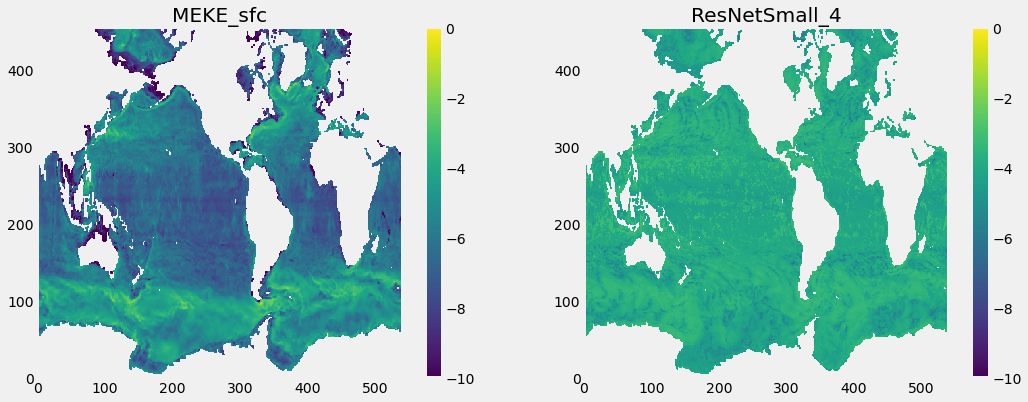

In [14]:
adaptive_scales=False

if adaptive_scales:
    mask_s = mask.squeeze()
    vmin = min(np.min(disp_target[mask_s]),
    np.min(disp_pred_mse[mask_s]))
    vmax = max(np.max(disp_target[mask_s]),
    np.max(disp_pred_mse[mask_s]))
else:
    vmin = -10
    vmax = 0

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.pcolormesh(disp_target, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('MEKE_sfc')
plt.subplot(1,2,2)
plt.pcolormesh(disp_pred_mse, vmin=vmin, vmax=vmax)
plt.title(f'{model_mse.name}')
plt.colorbar()
plt.draw()